In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Download and show the dataset
dataset = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
display(dataset.head())

# Separate features from label
raw_data = dataset.values
all_features = raw_data[:, 0:-1]
all_labels = raw_data[: , -1]

# Split the data into training and test portions
train_features, test_features, train_labels, test_labels = train_test_split(all_features, all_labels, test_size=0.1, random_state=21)

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [2]:
import tensorflow as tf

# Calculate the Min Value from the training set
min_val = tf.reduce_min(train_features)
max_val = tf.reduce_max(train_features)

# We perform MinMax Scaling
train_features = (train_features - min_val) / (max_val - min_val)
test_features = (test_features - min_val) / (max_val - min_val)

# We cast Tensors to the corrent dtype
train_features = tf.cast(train_features, tf.float32)
test_features = tf.cast(test_features, tf.float32)
train_labels = tf.cast(train_labels, tf.bool)
test_labels = tf.cast(test_labels, tf.bool)

In [3]:
# Divide training data into normal and anomalous data
normal_train_features = train_features[train_labels]
normal_test_features = test_features[test_labels]
anomalous_train_features = train_features[~train_labels]
anomalous_test_features = test_features[~test_labels]

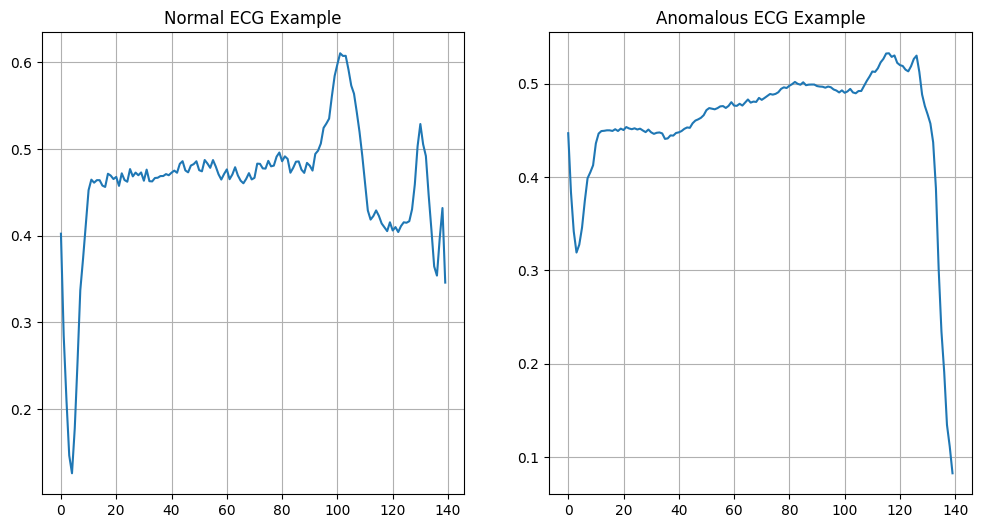

In [4]:
from matplotlib import pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
# Normal ECG Example
axes[0].grid()
axes[0].plot(np.arange(len(normal_train_features[0])), normal_train_features[0])
axes[0].set_title("Normal ECG Example")
axes[1].grid()
# Anomalous ECG Example
axes[1].plot(np.arange(len(anomalous_train_features[0])), anomalous_train_features[0])
axes[1].set_title("Anomalous ECG Example")
plt.show()

In [5]:
from keras import layers
from keras import Model

class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    # Encoding part
    self.encoder = tf.keras.Sequential([
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")
    ])
    # Decoding part
    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(140, activation="sigmoid")
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [6]:
# Compile the model
autoencoder.compile(optimizer='adam', loss='mae')

# Train the model
history = autoencoder.fit(
    normal_train_features, normal_train_features, 
    epochs=50, batch_size=128, validation_data=(test_features, test_features)
)


Epoch 1/50

21/21 [==============================] - 1s 8ms/step - loss: 0.0568 - val_loss: 0.0497
Epoch 2/50
21/21 [==============================] - 0s 2ms/step - loss: 0.0450 - val_loss: 0.0425
Epoch 3/50
21/21 [==============================] - 0s 2ms/step - loss: 0.0319 - val_loss: 0.0377
Epoch 4/50
21/21 [==============================] - 0s 2ms/step - loss: 0.0259 - val_loss: 0.0352
Epoch 5/50
21/21 [==============================] - 0s 2ms/step - loss: 0.0226 - val_loss: 0.0326
Epoch 6/50
21/21 [==============================] - 0s 2ms/step - loss: 0.0205 - val_loss: 0.0323
Epoch 7/50
21/21 [==============================] - 0s 2ms/step - loss: 0.0201 - val_loss: 0.0320
Epoch 8/50
21/21 [==============================] - 0s 2ms/step - loss: 0.0198 - val_loss: 0.0314
Epoch 9/50
21/21 [==============================] - 0s 2ms/step - loss: 0.0195 - val_loss: 0.0309
Epoch 10/50
21/21 [==============================] - 0s 2ms/step - loss: 0.0193 - val_loss: 0.0297
Epoch 11/50
21/21

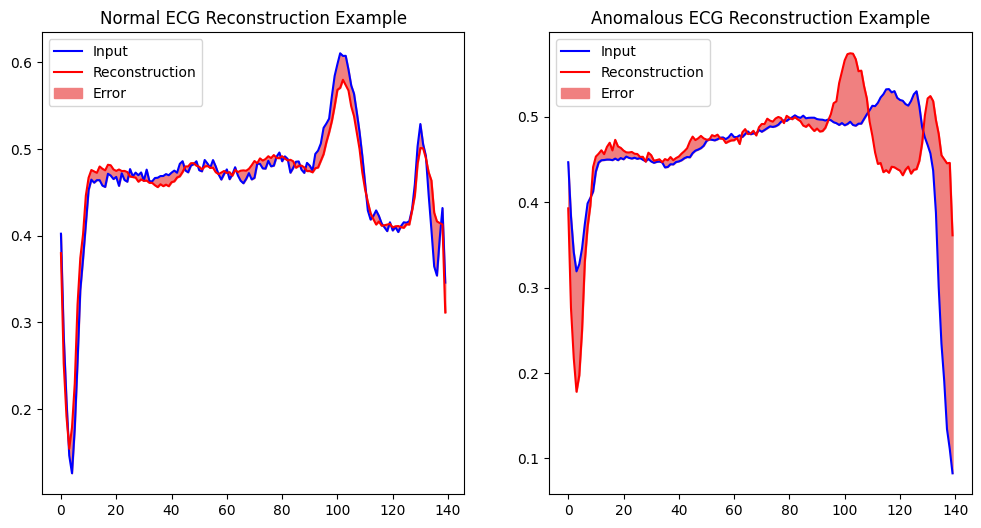

In [7]:
# Encoding and Decoding of Normal and Anomalous Features (ECGs)
encoded_normal_train_features = autoencoder.encoder(normal_train_features).numpy()
decoded_normal_train_features = autoencoder.decoder(encoded_normal_train_features).numpy()
encoded_anomalous_train_features = autoencoder.encoder(anomalous_train_features).numpy()
decoded_anomalous_train_features = autoencoder.decoder(encoded_anomalous_train_features).numpy()

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
# Normal ECG Reconstruction Example
axes[0].plot(normal_train_features[0], 'b')
axes[0].plot(decoded_normal_train_features[0], 'r')
axes[0].fill_between(np.arange(140), decoded_normal_train_features[0], normal_train_features[0], color='lightcoral')
axes[0].legend(labels=["Input", "Reconstruction", "Error"])
axes[0].set_title("Normal ECG Reconstruction Example")
# Anomalous ECG Reconstruction Example
axes[1].plot(anomalous_train_features[0], 'b')
axes[1].plot(decoded_anomalous_train_features[0], 'r')
axes[1].fill_between(np.arange(140), decoded_anomalous_train_features[0], anomalous_train_features[0], color='lightcoral')
axes[1].legend(labels=["Input", "Reconstruction", "Error"])
axes[1].set_title("Anomalous ECG Reconstruction Example")
plt.show()

59/59 [==============================] - 0s 617us/step


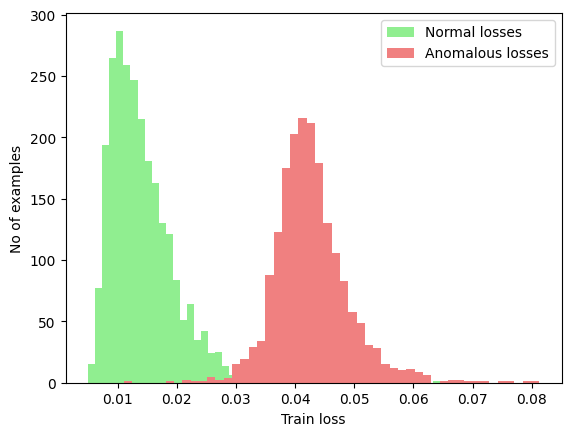

In [8]:
# Predictions for normal ECGs
normal_reconstructions = autoencoder.predict(normal_train_features)
normal_losses = tf.keras.losses.mae(normal_reconstructions, normal_train_features)

# Predictions for anomalous ECGs
anomalous_reconstructions = autoencoder.predict(anomalous_train_features)
anomalous_losses = tf.keras.losses.mae(anomalous_reconstructions, anomalous_train_features)

plt.hist(normal_losses[None,:], bins=50, color="lightgreen")
plt.hist(anomalous_losses[None,:], bins=50, color="lightcoral")
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.legend(labels=["Normal losses", "Anomalous losses"])
plt.show()

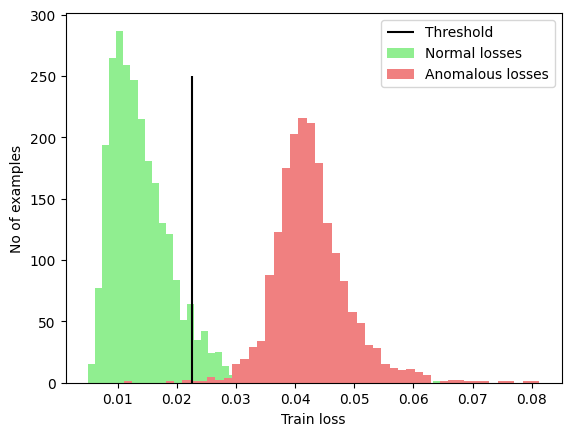

In [9]:
threshold = np.mean(normal_losses) + np.std(normal_losses)
plt.hist(normal_losses[None,:], bins=50, color="lightgreen")
plt.hist(anomalous_losses[None,:], bins=50, color="lightcoral")
plt.vlines(threshold, -0, 250, colors=["black"], label="threshold")
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.legend(labels=["Threshold", "Normal losses", "Anomalous losses"])
plt.show()

In [10]:
from sklearn.metrics import accuracy_score, recall_score, precision_score

def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))
  
preds = predict(autoencoder, test_features, threshold)
print_stats(preds, test_labels)

Accuracy = 0.94
Precision = 0.9924528301886792
Recall = 0.9037800687285223


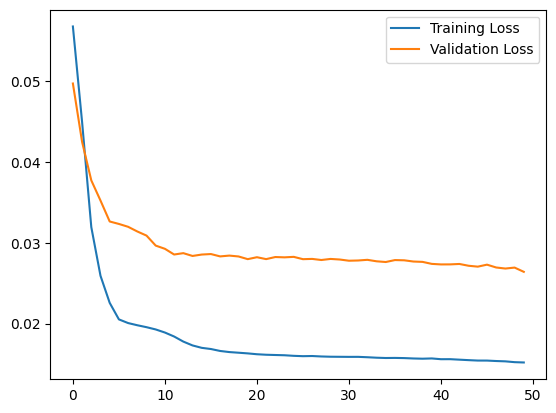

In [11]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()